# Load Dataset and Descriptive Stats

In [1]:
import pandas as pd
data = pd.read_csv('population_data.csv')
data.head()

,STATISTIC Label,Year,Component,UNIT,VALUE
0,Annual Population Change,1951,Annual births,Thousand,NaN
1,Annual Population Change,1951,Annual deaths,Thousand,NaN
2,Annual Population Change,1951,Natural increase,Thousand,26.6
3,Annual Population Change,1951,Immigrants,Thousand,NaN
4,Annual Population Change,1951,Emigrants,Thousand,NaN


In [2]:
# Check for missing values and data types
missing_values = data.isnull().sum()
data_types = data.dtypes
missing_values, data_types

(STATISTIC Label      0
 Year                 0
 Component            0
 UNIT                 0
 VALUE              144
 dtype: int64,
 STATISTIC Label     object
 Year                 int64
 Component           object
 UNIT                object
 VALUE              float64
 dtype: object)

The dataset contains 144 missing values in the VALUE column, which is critical for the analysis. The other columns have no missing values. The Year column is an integer, which is appropriate, and the VALUE column is a float, which also makes sense for continuous data.

Because the missing valuesa are a small portion of the data, removing them is the simplest solution


In [3]:
# Remove rows with missing 'VALUE'
data_cleaned = data.dropna(subset=['VALUE'])

In [4]:
# Central Tendency Measures
mean_value = data_cleaned['VALUE'].mean()
median_value = data_cleaned['VALUE'].median()
mode_value = data_cleaned['VALUE'].mode()[0] 

# Variation Measures
range_value = data_cleaned['VALUE'].max() - data_cleaned['VALUE'].min()
iqr_value = data_cleaned['VALUE'].quantile(0.75) - data_cleaned['VALUE'].quantile(0.25)
std_dev_value = data_cleaned['VALUE'].std()
variance_value = data_cleaned['VALUE'].var()

central_tendency_measures = {
    "Mean": mean_value,
    "Median": median_value,
    "Mode": mode_value
}

variation_measures = {
    "Range": range_value,
    "Interquartile Range (IQR)": iqr_value,
    "Standard Deviation": std_dev_value,
    "Variance": variance_value
}

central_tendency_measures, variation_measures

({'Mean': 633.2622727272728, 'Median': 35.55, 'Mode': 33.3},
 {'Range': 5339.6,
  'Interquartile Range (IQR)': 45.99999999999999,
  'Standard Deviation': 1378.6717177306743,
  'Variance': 1900735.7052704485})

These measures give us a general idea about the central tendency and variation of the VALUE column. The presence of a negative minimum value could indicate a decrease in some population-related statistic, such as a net loss due to emigration.

The large standard deviation and variance suggest there is a significant spread in the values. The mean is much higher than the median, which indicates that the data might be right-skewed due to some very high values.

# Distributions and Hypothesis Testing

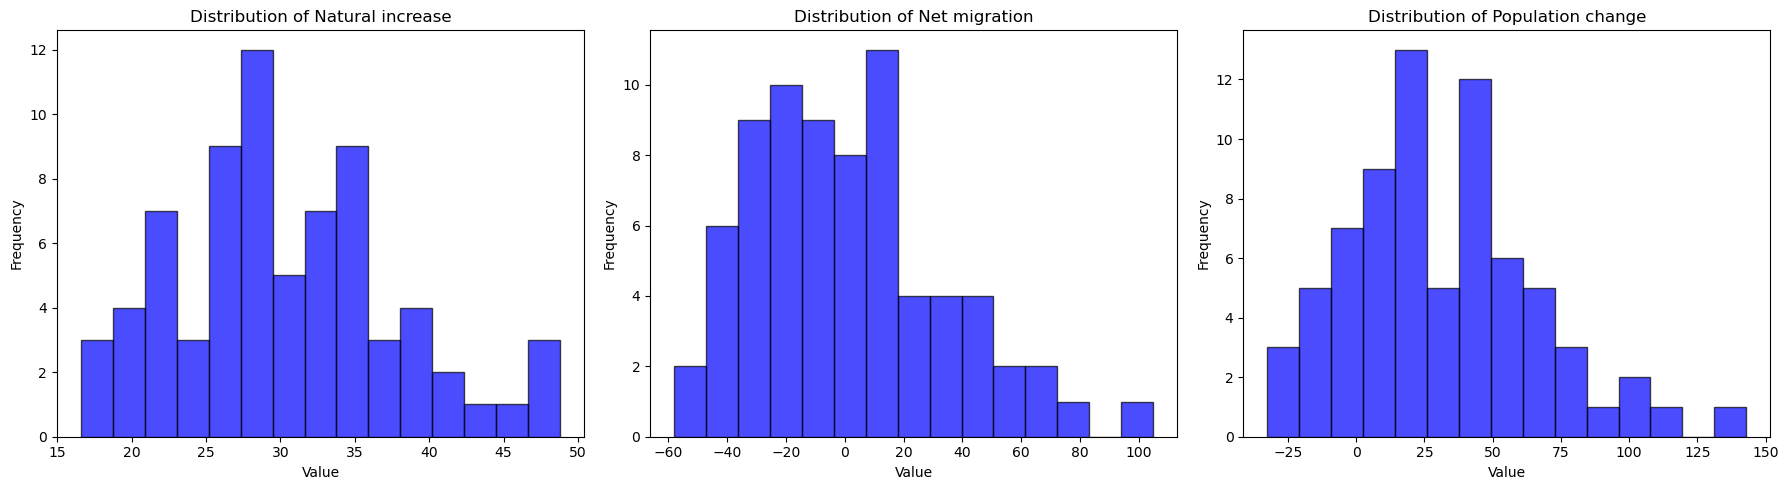

array(['Natural increase', 'Net migration', 'Population change',
       'Population', 'Annual births', 'Annual deaths', 'Immigrants',
       'Emigrants'], dtype=object)

In [5]:
# Check the unique values in the 'Component' column
unique_components = data_cleaned['Component'].unique()
import matplotlib.pyplot as plt

# Get the first three components
sample_components = unique_components[:3]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

for ax, component in zip(axes, sample_components):
    subset = data_cleaned[data_cleaned['Component'] == component]
    ax.hist(subset['VALUE'], bins=15, alpha=0.7, color='blue', edgecolor='black')
    ax.set_title(f'Distribution of {component}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

unique_components[:10] 

The Component column contains various population statistics such as 'Natural increase', 'Net migration', 'Population change', 'Population', 'Annual births', 'Annual deaths', 'Immigrants', and 'Emigrants'.

The histograms displayed above represent the distribution of VALUE for the first three components listed:

Natural increase
Net migration
Population change


Natural Increase: If this represents the net increase of population due to births and deaths, it might follow a normal distribution if the sample size is large enough, according to the Central Limit Theorem.

Net Migration: This could potentially follow a binomial distribution or a normal distribution for large samples.

Population Change: This is likely to follow a normal distribution as it could be the sum of various independent random variables.

In [6]:
from scipy.stats import shapiro

#test for normality
normality_results = {}

for component in sample_components:
    values = data_cleaned[data_cleaned['Component'] == component]['VALUE']
    stat, p_value = shapiro(values)
    normality_results[component] = {'Statistic': stat, 'p-value': p_value}

normality_results

{'Natural increase': {'Statistic': 0.978701651096344,
  'p-value': 0.25315892696380615},
 'Net migration': {'Statistic': 0.9665552377700806,
  'p-value': 0.04965019226074219},
 'Population change': {'Statistic': 0.9710056185722351,
  'p-value': 0.09061215072870255}}

Natural Increase:
Statistic: 0.979
p-value: 0.253
Net Migration:
Statistic: 0.967
p-value: 0.050
Population Change:
Statistic: 0.971
p-value: 0.091


For 'Natural Increase' and 'Population Change' the p-values are 0.253 and 0.091 which are above the common alpha level of 0.05. This means we fail to reject the null hypothesis of normality for these components, and the data could be considered normally distributed.

For 'Net Migration' the p-value is very close to 0.05 which is a borderline case. Depending on the chosen significance level, this might suggest that the data either just fails to reject or just rejects the null hypothesis of normality. 

In [7]:
# test for 'Annual births' and 'Annual deaths'
births_values = data_cleaned[data_cleaned['Component'] == 'Annual births']['VALUE']
deaths_values = data_cleaned[data_cleaned['Component'] == 'Annual deaths']['VALUE']

# Normality test for each component
births_normality = shapiro(births_values)
deaths_normality = shapiro(deaths_values)

# Perform a two-sample t-test if both samples are normally distributed
from scipy.stats import ttest_ind

if births_normality.pvalue > 0.05 and deaths_normality.pvalue > 0.05:
    t_stat, p_value = ttest_ind(births_values, deaths_values, equal_var=False)  # We assume unequal variances
else:
    t_stat, p_value = (None, None)

births_normality, deaths_normality, t_stat, p_value

(ShapiroResult(statistic=0.945901095867157, pvalue=0.0712183490395546),
 ShapiroResult(statistic=0.9764723777770996, pvalue=0.6091884970664978),
 21.538196686981948,
 1.0190940661538279e-23)

H0: μ_births - μ_deaths = 0 (The mean annual births is equal to the mean annual deaths)
H1: μ_births - μ_deaths ≠ 0 (The mean annual births is not equal to the mean annual deaths)

The test results for the Annual births and Annual deaths data are:

Annual Births:
Statistic: 0.946
p-value: 0.071
Annual Deaths:
Statistic: 0.976
p-value: 0.609

Both p-values are greater than 0.05, which means we fail to reject the null hypothesis of normality for both datasets. This suggests that both are normally distributed, so it is appropriate to proceed with a two-sample t-test.

The results of the two-sample t-test are:

T-Statistic: 21.538
p-value: approximately 1.02e-23
The p-value is much lower than the standard alpha level of 0.05, which means we reject the null hypothesis that the mean of Annual births is equal to the mean of Annual deaths. There is a statistically significant difference between the two means.

# Binomial Distributions

## Successful Migration

Let's assume n=10 trials (people trying to immigrate), and the probability of a successful immigration p is 0.3. We could calculate the probability distribution for k=0,1,2,…,10 successful immigrations.

In [8]:
from scipy.stats import binom
import numpy as np

# Define the parameters for the binomial distribution
n = 10  
p = 0.3  

# PMF for the binomial distribution
k_values = np.arange(0, n+1) 
binom_pmf = binom.pmf(k_values, n, p)

# Calculate the mean and variance of the binomial distribution
binom_mean = n * p
binom_variance = n * p * (1 - p)

binom_pmf, binom_mean, binom_variance

(array([2.82475249e-02, 1.21060821e-01, 2.33474441e-01, 2.66827932e-01,
        2.00120949e-01, 1.02919345e-01, 3.67569090e-02, 9.00169200e-03,
        1.44670050e-03, 1.37781000e-04, 5.90490000e-06]),
 3.0,
 2.0999999999999996)

The mean number of successes (μ) is 3.0
The variance (σ^2) is 2.1
The probability mass function (PMF) for the number of successes k from 0 to 10 is given by an array where each value corresponds to the probability of k successes:

P (X = k) = (k choose n) (p^k) ((1−p)^(n−k))

The most likely outcome is 3 successes, which is exactly the mean of the distribution. This is typical for a binomial distribution when n and p result in a mean that is an integer. The probabilities decrease as we move away from the mean, which is also characteristic of the binomial distribution.

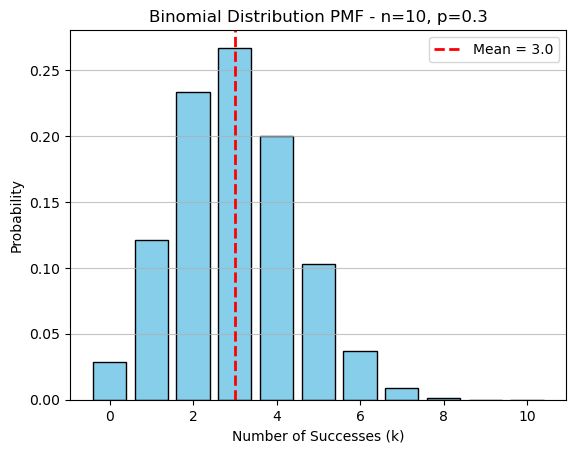

In [9]:
# Plot the PMF of the binomial distribution
plt.bar(k_values, binom_pmf, color='skyblue', edgecolor='black')

plt.axvline(binom_mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {binom_mean}')

plt.title('Binomial Distribution PMF - n=10, p=0.3')
plt.xlabel('Number of Successes (k)')
plt.ylabel('Probability')
plt.legend()
plt.grid(axis='y', alpha=0.75)

plt.show()

Here is the visualisation of the binomial distribution's probability mass function (PMF) with 
n=10 trials and a success probability p=0.3. 

The distribution is slightly right-skewed since the probability of success p is less than 0.5, which means the mode is to the left of the mean. The distribution's peak is at 3 successes, which corresponds to the mean, and probabilities taper off as the number of successes moves away from the mean

## Natural Increase Successes

In [10]:
# Calculate the median of 'Natural increase'
natural_increase_values = data_cleaned[data_cleaned['Component'] == 'Natural increase']['VALUE']
median_natural_increase = natural_increase_values.median()

# Define success as being above the median
successes = natural_increase_values > median_natural_increase

# Calculate the probability of success in a given year
p_success = successes.mean()

# Number of trials is the total number of years
n_trials = successes.count()

# Calculate the binomial probabilities for observing various numbers of successes
k_values_natural_increase = np.arange(0, n_trials+1)  
binom_pmf_natural_increase = binom.pmf(k_values_natural_increase, n_trials, p_success)

p_success, n_trials

(0.4931506849315068, 73)

In this hypothetical scenario, a success is defined as a year when the natural increase is above the median natural increase value for the dataset. 

Based on this definition:

The probability of success p in any given year is approximately 0.493.
The number of trials n, which corresponds to the number of years we have data for, is 73

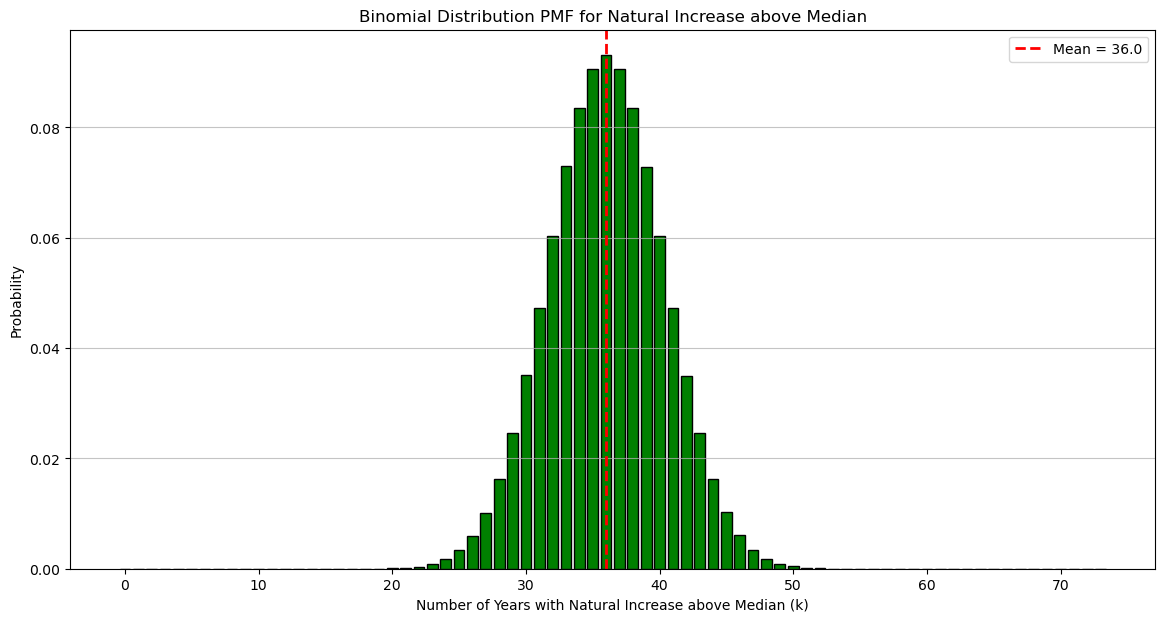

In [11]:
# Plot the PMF of the binomial distribution
plt.figure(figsize=(14, 7))
plt.bar(k_values_natural_increase, binom_pmf_natural_increase, color='green', edgecolor='black')

binom_mean_natural_increase = n_trials * p_success
plt.axvline(binom_mean_natural_increase, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {binom_mean_natural_increase}')

plt.title('Binomial Distribution PMF for Natural Increase above Median')
plt.xlabel('Number of Years with Natural Increase above Median (k)')
plt.ylabel('Probability')
plt.legend()
plt.grid(axis='y', alpha=0.75)

plt.show()

The visualization above displays the binomial distribution's probability mass function (PMF) for our scenario, where we define success as a year with a natural increase above the median value. This is based on 73 years of data (trials), with a probability of success p of approximately 0.493 in any given year.

Each bar in the graph represents the probability of having k years with a natural increase above the median. The red dashed line indicates the mean of the distribution.

From the graph, we can see that the distribution is nearly symmetric around the mean, which makes sense given that the probability of success is close to 0.5. The probabilities decrease as the number of successes deviates from the mean, which is around 36 years (half of 73, since p is close to 0.5).

## Positive Immigration

In [12]:
# Calculate the number of years with positive net migration
net_migration_values = data_cleaned[data_cleaned['Component'] == 'Net migration']['VALUE']
positive_net_migration = net_migration_values > 0

# Calculate the probability of success in a given year
p_positive_net_migration = positive_net_migration.mean()

# Number of trials is the total number of years
n_trials_net_migration = positive_net_migration.count()

# Calculate the binomial probabilities for observing various numbers of successes
k_values_net_migration = np.arange(0, n_trials_net_migration+1)  
binom_pmf_net_migration = binom.pmf(k_values_net_migration, n_trials_net_migration, p_positive_net_migration)

p_positive_net_migration, n_trials_net_migration

(0.4520547945205479, 73)

For this scenario, a success is defined as a year when net migration is positive. 

Based on the data:

The probability of success p in any given year is approximately 0.452.
The number of trials n is 73.

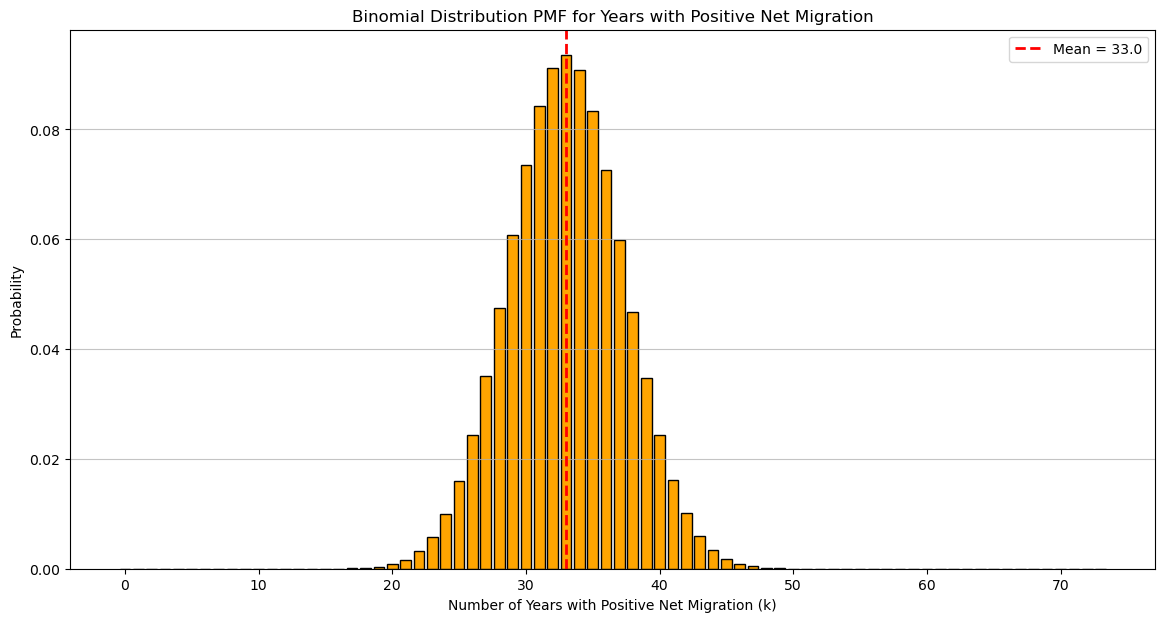

In [13]:
# Plot the PMF of the net migration scenario
plt.figure(figsize=(14, 7))
plt.bar(k_values_net_migration, binom_pmf_net_migration, color='orange', edgecolor='black')

binom_mean_net_migration = n_trials_net_migration * p_positive_net_migration
plt.axvline(binom_mean_net_migration, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {binom_mean_net_migration}')

plt.title('Binomial Distribution PMF for Years with Positive Net Migration')
plt.xlabel('Number of Years with Positive Net Migration (k)')
plt.ylabel('Probability')
plt.legend()
plt.grid(axis='y', alpha=0.75)

plt.show()

Here is the binomial distribution's probability mass function (PMF) for the scenario where success is defined as a year with positive net migration. This is based on 73 years of data, with a probability of success p of approximately 0.452 in any given year.

Each bar represents the probability of observing k years with positive net migration out of the 73 years. The red dashed line indicates the mean number of successful years, which in this case is the product of the number of trials (73 years) and the probability of success (0.452).

The distribution is almost symmetric around the mean, which is slightly lower than the halfway mark of 36.5 years due to the probability of success being less than 0.5. The graph shows the likelihood of various outcomes, with the highest probability centered around the mean. The probabilities tail off for outcomes that are significantly higher or lower than the expected mean number of successes

# Poisson Distribution

## Annual Births 

PMF of the Poisson distribution for this range of annual births. 

The PMF will show us the probability of observing a certain number of births in a year given our average rate.

In [14]:
from scipy.stats import poisson

# Calculate the average rate for 'Annual births'
annual_births = data_cleaned[data_cleaned['Component'] == 'Annual births']['VALUE']
lambda_births = annual_births.mean()

# Generate the PMF for various values of k around the mean 
k_values_births = np.arange(0, int(lambda_births)*2)
poisson_pmf_births = poisson.pmf(k_values_births, lambda_births)

lambda_births, poisson_pmf_births

(60.105405405405406,
 array([7.88050592e-27, 4.73661003e-25, 1.42347933e-23, 2.85196008e-22,
        4.28545542e-21, 5.15158070e-20, 5.16063078e-19, 4.43116864e-18,
        3.32921485e-17, 2.22337564e-16, 1.33636894e-15, 7.30209065e-15,
        3.65745933e-14, 1.69102366e-13, 7.25997589e-13, 2.90909196e-12,
        1.09282595e-11, 3.86380863e-11, 1.29019880e-10, 4.08146957e-10,
        1.22659192e-09, 3.51070497e-09, 9.59147026e-09, 2.50651830e-08,
        6.27730410e-08, 1.50919963e-07, 3.48888676e-07, 7.76670196e-07,
        1.66721704e-06, 3.45547434e-06, 6.92308953e-06, 1.34230678e-05,
        2.52124667e-05, 4.59213798e-05, 8.11800926e-05, 1.39410354e-04,
        2.32758773e-04, 3.78109740e-04, 5.98064190e-04, 9.21715144e-04,
        1.38500156e-03, 2.03039220e-03, 2.90565587e-03, 4.06152614e-03,
        5.54817443e-03, 7.41056163e-03, 9.68293068e-03, 1.23829037e-02,
        1.55058218e-02, 1.90200756e-02, 2.28641871e-02, 2.69462988e-02,
        3.11465041e-02, 3.53221369e-02, 3.9

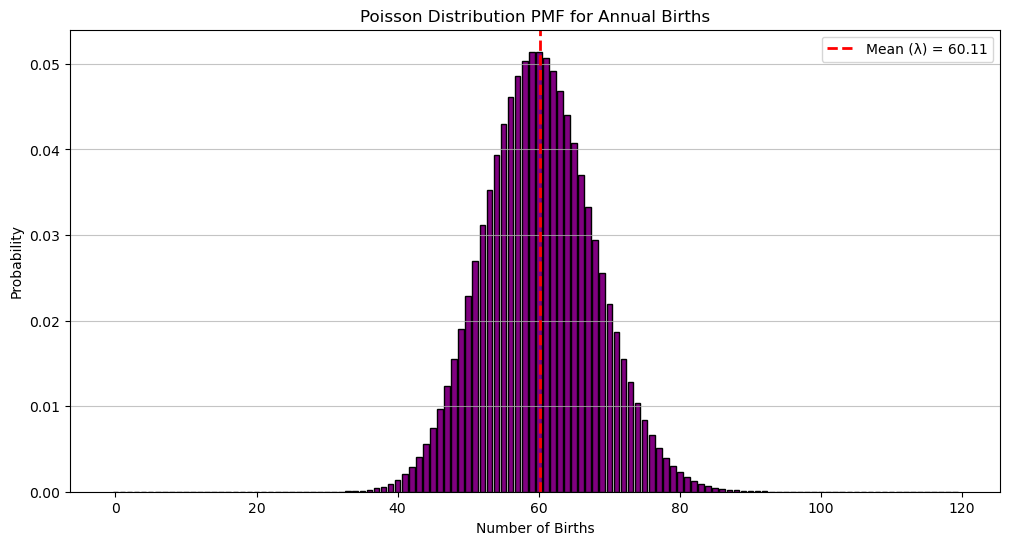

In [15]:
# PMF of the Poisson distribution for Annual births
plt.figure(figsize=(12, 6))
plt.bar(k_values_births, poisson_pmf_births, color='purple', edgecolor='black')

plt.axvline(lambda_births, color='red', linestyle='dashed', linewidth=2, label=f'Mean (λ) = {lambda_births:.2f}')

plt.title('Poisson Distribution PMF for Annual Births')
plt.xlabel('Number of Births')
plt.ylabel('Probability')
plt.legend()
plt.grid(axis='y', alpha=0.75)

plt.show()

Each bar represents the probability of observing a specific number of births in a year, given the average rate (λ) of 60.11 births per year.

The red dashed line indicates the mean of the distribution. This graph shows that the most likely number of births in a year is around the mean, with the probability decreasing for numbers of births that are significantly higher or lower than the average.

## Annual Deaths

Compute the average annual number of deaths to determine λ.
Generate the Poisson probabilities for a range of annual death counts around the average.

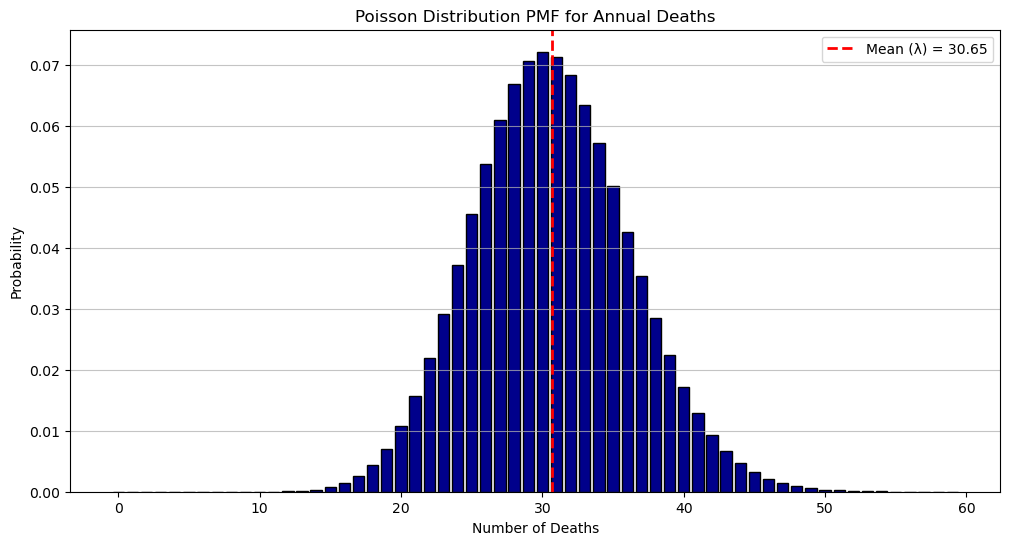

(30.651351351351348,
 array([4.87851051e-14, 1.49532940e-12, 2.29169334e-11, 2.34144992e-10,
        1.79421511e-09, 1.09990235e-08, 5.61891558e-08, 2.46039079e-07,
        9.42678784e-07, 3.21048651e-06, 9.84057501e-06, 2.74206293e-05,
        7.00399452e-05, 1.65139921e-04, 3.61554409e-04, 7.38808749e-04,
        1.41534291e-03, 2.55189252e-03, 4.34549745e-03, 7.01028259e-03,
        1.07437317e-02, 1.56814236e-02, 2.18480375e-02, 2.91161685e-02,
        3.71854129e-02, 4.55913262e-02, 5.37475292e-02, 6.10160889e-02,
        6.67937707e-02, 7.05972184e-02, 7.21300049e-02, 7.13187781e-02,
        6.83130290e-02, 6.34511107e-02, 5.72018320e-02, 5.00946700e-02,
        4.26519259e-02, 3.53334910e-02, 2.85005065e-02, 2.23994625e-02,
        1.71643449e-02, 1.28319601e-02, 9.36468854e-03, 6.67535718e-03,
        4.65019814e-03, 3.16744127e-03, 2.11057294e-03, 1.37642368e-03,
        8.78942618e-04, 5.49811817e-04, 3.37049503e-04, 2.02569074e-04,
        1.19404151e-04, 6.90546902e-05, 3.9

In [16]:
# Calculate the average rate for Annual deaths
annual_deaths = data_cleaned[data_cleaned['Component'] == 'Annual deaths']['VALUE']
lambda_deaths = annual_deaths.mean()

# PMF for various values of k around the mean
k_values_deaths = np.arange(0, int(lambda_deaths)*2)  
poisson_pmf_deaths = poisson.pmf(k_values_deaths, lambda_deaths)

plt.figure(figsize=(12, 6))
plt.bar(k_values_deaths, poisson_pmf_deaths, color='darkblue', edgecolor='black')

plt.axvline(lambda_deaths, color='red', linestyle='dashed', linewidth=2, label=f'Mean (λ) = {lambda_deaths:.2f}')

plt.title('Poisson Distribution PMF for Annual Deaths')
plt.xlabel('Number of Deaths')
plt.ylabel('Probability')
plt.legend()
plt.grid(axis='y', alpha=0.75)

plt.show()

lambda_deaths, poisson_pmf_deaths

The average annual number of deaths is approximately 30.65.

Each bar represents the probability of observing a certain number of deaths in a year, given the average rate of approximately 30.65 deaths per year.

The red dashed line indicates the mean of the distribution.

## Emigrants

Calculate the average annual number of emigrants to determine λ for the Poisson distribution.
Generate the Poisson PMF for a range of possible emigrant counts around the average to understand the distribution.

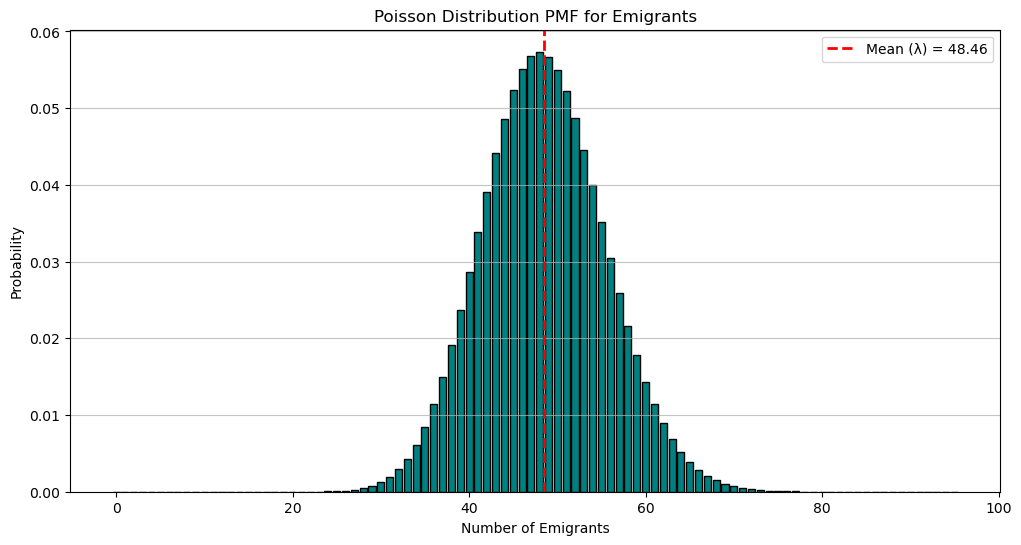

(48.45945945945945,
 array([9.00169224e-22, 4.36217140e-20, 1.05694234e-18, 1.70729515e-17,
        2.06836500e-16, 2.00463700e-15, 1.61906042e-14, 1.12083990e-13,
        6.78941196e-13, 3.65568038e-12, 1.77152295e-11, 7.80427678e-11,
        3.15159195e-10, 1.17480340e-09, 4.06645271e-09, 1.31372067e-08,
        3.97888709e-08, 1.13420422e-07, 3.05349575e-07, 7.78793439e-07,
        1.88699545e-06, 4.35441808e-06, 9.59148847e-06, 2.02086238e-05,
        4.08041244e-05, 7.90938324e-05, 1.47417091e-04, 2.64583427e-04,
        4.57913210e-04, 7.65180229e-04, 1.23600734e-03, 1.93213702e-03,
        2.92594737e-03, 4.29666145e-03, 6.12393798e-03, 8.47893498e-03,
        1.14134613e-02, 1.49483828e-02, 1.90629092e-02, 2.36866225e-02,
        2.86960230e-02, 3.39169211e-02, 3.91332301e-02, 4.41017483e-02,
        4.85715201e-02, 5.23055468e-02, 5.51021419e-02, 5.68131917e-02,
        5.73570117e-02, 5.67242813e-02, 5.49765602e-02, 5.22379292e-02,
        4.86811887e-02, 4.45106432e-02, 3.99

In [17]:
# Calculate the average rate for 'Emigrants'
emigrants = data_cleaned[data_cleaned['Component'] == 'Emigrants']['VALUE']
lambda_emigrants = emigrants.mean()

# PMF for various values of k around the mean (lambda)
k_values_emigrants = np.arange(0, int(lambda_emigrants)*2) 
poisson_pmf_emigrants = poisson.pmf(k_values_emigrants, lambda_emigrants)

plt.figure(figsize=(12, 6))
plt.bar(k_values_emigrants, poisson_pmf_emigrants, color='teal', edgecolor='black')

plt.axvline(lambda_emigrants, color='red', linestyle='dashed', linewidth=2, label=f'Mean (λ) = {lambda_emigrants:.2f}')

plt.title('Poisson Distribution PMF for Emigrants')
plt.xlabel('Number of Emigrants')
plt.ylabel('Probability')
plt.legend()
plt.grid(axis='y', alpha=0.75)

plt.show()

lambda_emigrants, poisson_pmf_emigrants

The average annual number of emigrants is approximately 48.46. 

Each bar represents the probability of observing a specific number of emigrants in a year, given the average rate of approximately 48.46 emigrants per year.

The red dashed line indicates the mean of the distribution, which is also the expected number of emigrants per year based on the historical average.

# Normal Distribution

## Population

Calculate the mean and standard deviation of the Population data.
Generate a range of population values.
Calculate the probability density function (PDF) for these values to visualise the normal distribution.

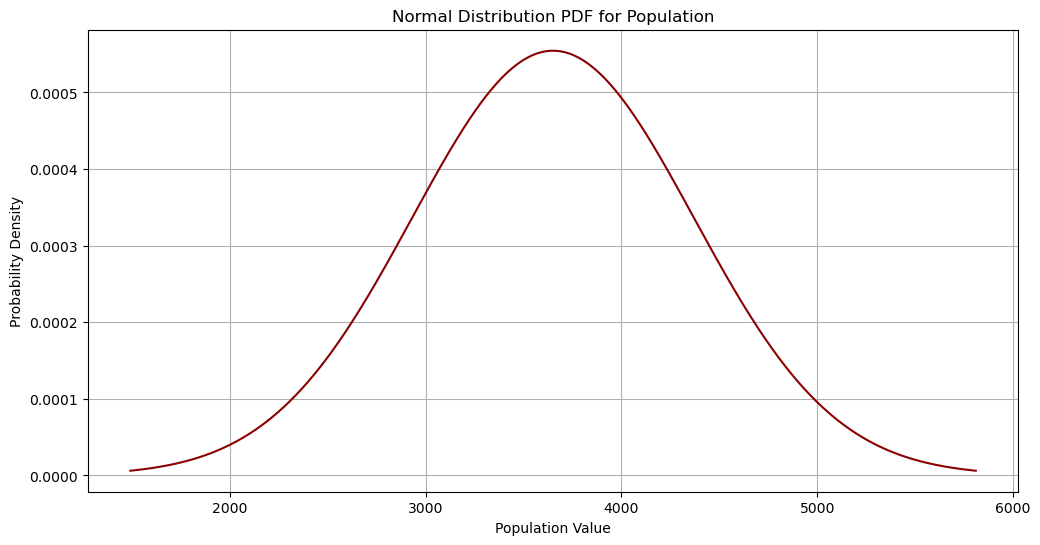

(3650.5328767123283, 719.507144404108)

In [18]:
from scipy.stats import norm

# Calculate the mean and standard deviation for Population
population_values = data_cleaned[data_cleaned['Component'] == 'Population']['VALUE']
mean_population = population_values.mean()
std_dev_population = population_values.std()

# Generate a range of population values for the normal distribution
population_range = np.linspace(mean_population - 3*std_dev_population, mean_population + 3*std_dev_population, 1000)
# PDF for these values
normal_pdf_population = norm.pdf(population_range, mean_population, std_dev_population)

plt.figure(figsize=(12, 6))
plt.plot(population_range, normal_pdf_population, color='darkred')

plt.title('Normal Distribution PDF for Population')
plt.xlabel('Population Value')
plt.ylabel('Probability Density')
plt.grid(True)

plt.show()

mean_population, std_dev_population

The average value for the 'Population' component is approximately 3650.53, and the standard deviation is approximately 719.51. 

The plot shows the bell curve of the normal distribution centered around the mean population value. It represents the probability density of population values, indicating that values closer to the mean are more probable than those further away.

## Net Migration

Calculate the mean and standard deviation of the Net migration data.
Generate a range of net migration values.
Calculate the probability density function (PDF) for these values to visualise the normal distribution.

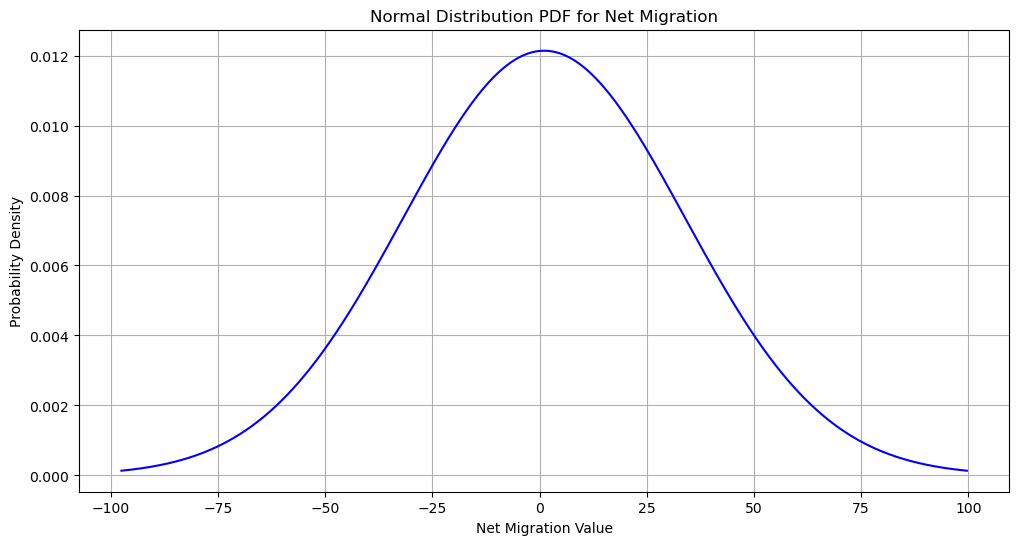

(1.0780821917808214, 32.866464868275614)

In [19]:
# Calculate the mean and standard deviation for Net migration
net_migration_values = data_cleaned[data_cleaned['Component'] == 'Net migration']['VALUE']
mean_net_migration = net_migration_values.mean()
std_dev_net_migration = net_migration_values.std()

# Generate a range of net migration values for the normal distribution
net_migration_range = np.linspace(mean_net_migration - 3*std_dev_net_migration, mean_net_migration + 3*std_dev_net_migration, 1000)
# PDF for these values
normal_pdf_net_migration = norm.pdf(net_migration_range, mean_net_migration, std_dev_net_migration)

plt.figure(figsize=(12, 6))
plt.plot(net_migration_range, normal_pdf_net_migration, color='blue')

plt.title('Normal Distribution PDF for Net Migration')
plt.xlabel('Net Migration Value')
plt.ylabel('Probability Density')
plt.grid(True)

plt.show()

mean_net_migration, std_dev_net_migration

The average value for the 'Net migration' component is approximately 1.08, and the standard deviation is approximately 32.87. 

The plot shows the bell-shaped curve of the normal distribution centered around the mean net migration value. It represents the probability density of net migration values, with the highest probability density at the mean. This suggests that net migration figures are most likely to be around the mean, with the likelihood decreasing for figures that are further away from this central value.

## Annual Deaths

H0: μ = 50
H1: μ ≠ 50
We'll perform the following steps:

Calculate the sample mean and standard deviation (s) of Annual deaths.
Determine the sample size (n).
Conduct a z-test to compare the sample mean to the historical mean.
Decide whether to reject the null hypothesis based on the z-score and the p-value.

In [20]:
from scipy.stats import norm

# Historical mean
historical_mean_deaths = 50

# Calculate the sample mean and standard deviation for Annual deaths
annual_deaths = data_cleaned[data_cleaned['Component'] == 'Annual deaths']['VALUE']
sample_mean_deaths = annual_deaths.mean()
sample_std_dev_deaths = annual_deaths.std()
sample_size_deaths = annual_deaths.count()

# Calculate the standard error of the mean
std_error_deaths = sample_std_dev_deaths / np.sqrt(sample_size_deaths)

# Conduct a one-sample z-test
z_score = (sample_mean_deaths - historical_mean_deaths) / std_error_deaths

# Calculate the p-value from the z-score
p_value = norm.sf(abs(z_score)) * 2  # two-tailed test

z_score, p_value, sample_mean_deaths, sample_std_dev_deaths, sample_size_deaths

(-59.58940398237422, 0.0, 30.651351351351348, 1.9750698470942492, 37)

The results of the one-sample z-test on the 'Annual deaths' data are as follows:

Calculated z-score: -59.59

p-value: 0.0 

Sample mean : 30.65

Sample standard deviation (s): 1.98

Sample size (n): 37

Given the extremely large z-score and a p-value of approximately 0, we reject the null hypothesis. This suggests that the current mean annual number of deaths is significantly different from the historical mean of 50 deaths per year. The sample mean of approximately 30.65 is much less than the historical mean I was testing against.

The p-value is effectively zero, which means that the probability of observing such a difference or more extreme by chance is extremely low, assuming that the null hypothesis is true.

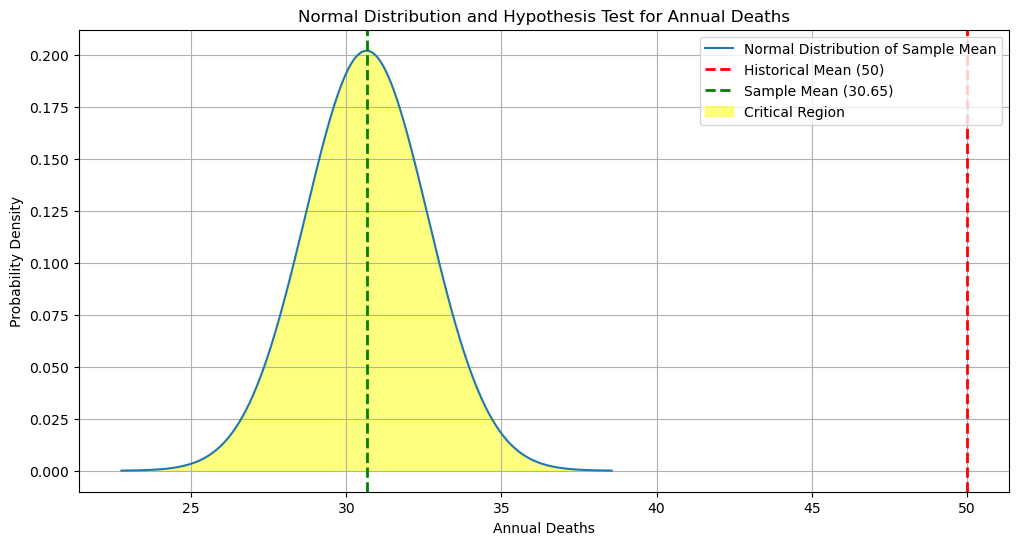

In [21]:
# Plot the normal distribution for Annual deaths and the historical mean
plt.figure(figsize=(12, 6))

x_values = np.linspace(sample_mean_deaths - 4*sample_std_dev_deaths, sample_mean_deaths + 4*sample_std_dev_deaths, 1000)
y_values = norm.pdf(x_values, sample_mean_deaths, sample_std_dev_deaths)
plt.plot(x_values, y_values, label='Normal Distribution of Sample Mean')

plt.axvline(historical_mean_deaths, color='red', linestyle='dashed', linewidth=2, label=f'Historical Mean ({historical_mean_deaths})')

plt.axvline(sample_mean_deaths, color='green', linestyle='dashed', linewidth=2, label=f'Sample Mean ({sample_mean_deaths:.2f})')

# Highlight the critical regions
critical_value = norm.ppf(0.975, sample_mean_deaths, std_error_deaths)  # 95% confidence interval for two-tailed test
plt.fill_between(x_values, y_values, where=(x_values >= critical_value) | (x_values <= historical_mean_deaths - (critical_value - sample_mean_deaths)), color='yellow', alpha=0.5, label='Critical Region')

plt.title('Normal Distribution and Hypothesis Test for Annual Deaths')
plt.xlabel('Annual Deaths')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)

plt.show()

The green dashed line represents the sample mean (approximately 30.65).

The red dashed line indicates the historical mean (50 deaths per year) that we used as our null hypothesis.

The shaded yellow areas represent the critical regions for a two-tailed hypothesis test at the 95% confidence level. Because our sample mean is well outside of the historical mean and does not overlap with the critical regions, this visual reinforces our statistical test conclusion that the sample mean is significantly different from the historical mean.

The extremely low p-value suggests that the difference we observed is highly unlikely to have occurred by chance, confirming that the mean annual number of deaths has significantly decreased compared to the historical figure of 50 deaths per year